# Perform bias correction on downscaled data

Downscaling climate data from coarse global models (GCMs) improves spatial resolution but often introduces systematic errors, known as biases. These biases can result from:

- **Model simplifications**: GCMs use approximations to represent complex physical processes, leading to discrepancies between model outputs and observed data.
- **Local geography**: Coarse models may miss small-scale features (e.g., topography), affecting the accuracy of climate variables like temperature and rainfall.
- **Interpolation assumptions**: Downscaling involves assumptions that may not capture local climate dynamics, causing additional inaccuracies.

Bias correction adjusts systematic errors in downscaled climate data by aligning model outputs with ground data. This process improves the accuracy and reliability of climate projections, making them more suitable for local decision-making. 

In [45]:
import os, sys
from pathlib import Path
import time

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr
import xskillscore as xs
from cmethods import adjust

from functools import partial
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob

import sys
import ast
sys.path.append("../../") 
from src.assess_model import *
from src.downscaling_utils import *

## Import libraries

In [46]:
RAW_INPUT_PATH = Path("../../data/01-raw/")
INPUT_PATH = Path("../../data/02-processed/")
RESULTS_PATH = Path("../../data/03-results/")
YEARS = np.arange(2003,2023,1)
VARIABLE = 'tmin'
metrics_columns = ['rmse','mae','binary_accuracy']
if VARIABLE == 'precip': 
    evaluation_years = [2008,2009,2010,2016,2017,2018]
    VARIABLE_LR = 'tp'
elif VARIABLE in ['tmin', 'tmax']: 
    evaluation_years = [2008,2009,2010,2016]
    VARIABLE_LR = 't2m_min' if VARIABLE=='tmin' else 't2m_max'

## Read bounds

In [47]:
bounds_df = pd.read_csv(RAW_INPUT_PATH / 'domains' / 'downscaling_domains_fixed.csv')
bounds_df['full_bounds'] = bounds_df['full_bounds'].apply(ast.literal_eval)
bounds_df['focused_bounds'] = bounds_df['focused_bounds'].apply(ast.literal_eval)
bounds_df.head()

,city,full_bounds,focused_bounds
0,Dagupan,"[120.00931049408791, 120.4821769636825, 15.907...","[120.210342, 120.450668, 15.928978, 16.138177]"
1,Palayan,"[120.8625098711998, 121.33347866342953, 15.294...","[121.042557, 121.131134, 15.495371, 15.584679]"
2,MetroManila,"[120.8470354518582, 121.22452516891933, 14.273...","[120.8670354518582, 121.20452516891933, 14.293..."
3,Legazpi,"[123.63316781038878, 123.90749473184147, 12.97...","[123.68657, 123.767166, 13.113921, 13.205771]"
4,Iloilo,"[122.41374050886832, 122.69006942567574, 10.61...","[122.477646, 122.602422, 10.676429, 10.80698]"


In [48]:
OUTPUT_CITY_NAMES = bounds_df['city'].unique()
# Alternatively, provide a selected list of cities to perform bias correction on
# OUTPUT_CITY_NAMES = ["Dagupan","Zamboanga"]

## Read station locations

In [49]:
station_locations_df = pd.read_csv(RAW_INPUT_PATH/'station_data'/'PAGASA_station_locations.csv')
station_locations_df = station_locations_df.dropna()
STATION_NAMES = station_locations_df['station_name'].values
STATION_CITY_NAMES = station_locations_df['city_name'].values
STATION_CITY_NAMES

array(['Palayan', 'Dagupan', 'Davao', 'CagayanDeOro', 'CagayanDeOro',
       'Legazpi', 'Mandaue', 'Muntinlupa', 'Navotas', 'Mandaluyong',
       'Tacloban', 'Zamboanga', 'Iloilo'], dtype=object)

In [ ]:
# Alternatively, provide a selected list of stations to perform bias correction on
# STATION_CITY_NAMES = ["Dagupan","Zamboanga"]

## Read downscaled model output

In [50]:
output_ds_list = {}
for city_name in OUTPUT_CITY_NAMES:
    out_ds = xr.load_dataset(RESULTS_PATH / VARIABLE / f"downscaled_{VARIABLE}_{city_name.lower()}.nc")
    out_ds = out_ds[VARIABLE]
    output_ds_list.update({city_name: out_ds})

## Read station data
- Kindly request for station data through the [PAGASA climate data request site](https://www.pagasa.dost.gov.ph/climate/climate-data)

In [53]:
# Read station data in netCDF
station_ds_list = {}
for city_name in STATION_CITY_NAMES:
    stn_ds = xr.load_dataset(INPUT_PATH / "station_data" / f"pagasa_station_{city_name.lower()}.nc")
    stn_ds = stn_ds[VARIABLE]
    station_ds_list.update({city_name: stn_ds})

## Bias correct using quantile mapping and save

In [56]:
for city_name in np.unique(STATION_CITY_NAMES):
    print(f"Processing city {city_name}...", end='')
    # The Metro Manila output file contains 3 cities
    output_city_name = 'MetroManila' if city_name in ['Muntinlupa', 'Navotas', 'Mandaluyong'] else city_name
    output_ds=output_ds_list[output_city_name]
    station_ds = station_ds_list[city_name]
    corrected_output_ds = correct_gridded_cmethods(
                output_ds,
                station_ds[:, 0, 0].drop_vars(["lat", "lon"]),
                group='quantile_mapping',
                should_align=False,
                n_quantiles=100)
    corrected_output_ds.to_netcdf(RESULTS_PATH/ VARIABLE /f'downscaled_{VARIABLE}_{output_city_name.lower()}_corrected.nc')
    print('DONE!')

Processing city CagayanDeOro...DONE!
Processing city Dagupan...DONE!
Processing city Davao...DONE!
Processing city Iloilo...DONE!
Processing city Legazpi...DONE!
Processing city Mandaluyong...DONE!
Processing city Mandaue...DONE!
Processing city Muntinlupa...DONE!
Processing city Navotas...DONE!
Processing city Palayan...DONE!
Processing city Tacloban...DONE!
Processing city Zamboanga...DONE!


## Sense-check output

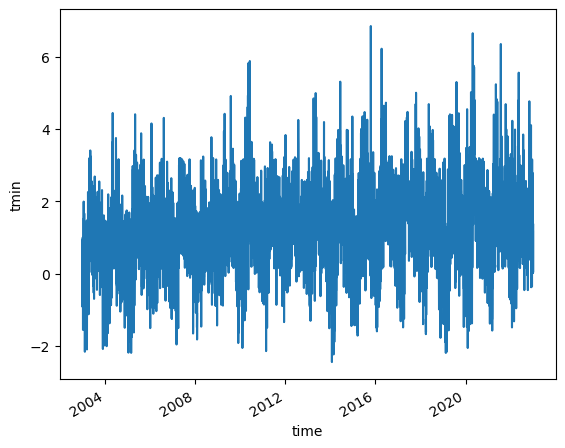

In [19]:
x = output_ds.mean(dim=['lat','lon'])
cx = corrected_output_ds.mean(dim=['lat','lon'])
diff = x-cx
diff.plot()